### First, make a 2D gaussian distribution with 𝑚𝑒𝑎𝑛 = [− 5, 5] and 𝑐𝑜𝑣 = 5𝐼 where I is the identity matrix; then plot it

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

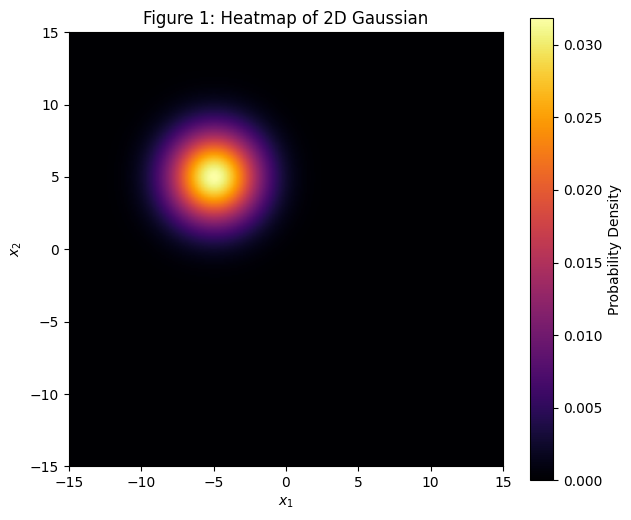

In [ ]:
# Define parameters for the 2D Gaussian
mean = np.array([-5, 5])  # Mean vector
cov = 5 * np.eye(2)  # Covariance matrix (5 times identity matrix)

x1_range = np.linspace(-15, 15, 300)
x2_range = np.linspace(-15, 15, 300)
X1, X2 = np.meshgrid(x1_range, x2_range)
pos = np.dstack((X1, X2))

# Compute the 2D Gaussian PDF values at each grid point
rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

plt.figure(figsize=(7, 6))
plt.imshow(Z, extent=[-15, 15, -15, 15], origin='lower', cmap='Reds', alpha=1) #xmap could be Reds or inferno
plt.colorbar(label="Probability Density")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Figure 1: Heatmap of 2D Gaussian")
plt.show()


# Score Function for a 2D Gaussian Distribution

The **score function** is the gradient of the log-probability density function (log-PDF):

$$
S(x) = \nabla_x \log p(x)
$$

where $ p(x) $ is the probability density function (PDF) of a 2D Gaussian:

$$p(x) = \frac{1}{2\pi |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)$$

- $ x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} $ is the **random variable (2D vector)**.
- $ \mu = \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix} $ is the **mean vector**.
- $ \Sigma $ is the **covariance matrix**.
- $ |\Sigma| $ is the **determinant of the covariance matrix**.
- $ \Sigma^{-1} $ is the **inverse of the covariance matrix**.

### **Step 1: Compute $ \log p(x) $**

$$\log p(x) = -\frac{1}{2} \log (2\pi |\Sigma|) - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)$$

The first term is a constant and disappears when taking the gradient.

### **Step 2: Compute the Gradient $ \nabla_x \log p(x) $**

$$S(x) = \nabla_x \log p(x) = \nabla_x \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$$

we use the standard gradient rule for a quadratic form:  $ \nabla_x \left( (x - \mu)^T A (x - \mu) \right) = 2 A (x - \mu) $ where $ A $ is a symmetric matrix. So:

$$\nabla_x \left( (x - \mu)^T \Sigma^{-1} (x - \mu) \right) = 2 \Sigma^{-1} (x - \mu)$$

Thus, the final score function is:

$S(x) = - \Sigma^{-1} (x - \mu)$ => If $ \Sigma = 5I $, then: $\Sigma^{-1} = \begin{bmatrix} \frac{1}{5} & 0 \\ 0 & \frac{1}{5} \end{bmatrix}$

So the score function simplifies to:

$$
S(x) = -\frac{1}{5} (x - \mu)
$$

This means the further $ x $ is from $ \mu $, the stronger the pull toward $ \mu $.

### Then you need to implement the score function theoretically with the provided formula and pdf of the distribution. To make sure that you have calculated the score function correctly,you can plot a quiver from points of the grid to their corresponding score.

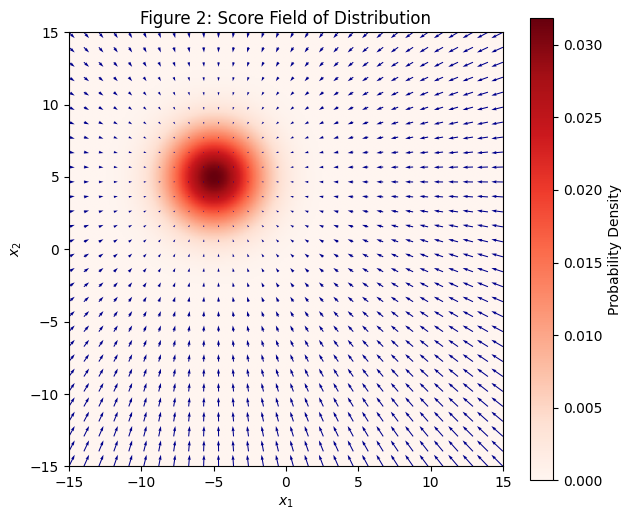

In [110]:
cov_inv = np.linalg.inv(cov) 

x1_range = np.linspace(-15, 15, 30)
x2_range = np.linspace(-15, 15, 30)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Compute the score function (gradient of log-PDF)
U = - (1/5) * (X1 - mean[0])  # X1-component of score function
V = - (1/5) * (X2 - mean[1])  # X2-component of score function

plt.figure(figsize=(7, 6))
plt.imshow(Z, extent=[-15, 15, -15, 15], origin='lower', cmap='Reds', alpha=1)
plt.colorbar(label="Probability Density")

# Plot the quiver (score function field)
plt.quiver(X1, X2, U, V, color='darkblue', angles='xy', scale_units='xy', scale=5)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Figure 2: Score Field of Distribution")

plt.show()


### Implement a function which takes an array of initial points and runs langevin dynamics on them and returns the converged samples. To see the progress of the algorithm, you should keep a trajectory of points and plot them:

In [111]:
def langevin_sampling(initial_point, mean, cov, step_size=0.1, num_steps=100):

    cov_inv = np.linalg.inv(cov)
    
    # Initialize sample at the initial point
    x = np.array(initial_point, dtype=np.float64)
    
    trajectory = [x]
    
    for _ in range(num_steps):
        # Compute score function S(x) = -Σ⁻¹ (x - μ)
        score = - np.dot(cov_inv, (x - mean))
        
        # Add gradient update + noise
        x = x + step_size * score + np.sqrt(2 * step_size) * np.random.normal(size=x.shape)

        trajectory.append(x)
    
    return np.array(trajectory)

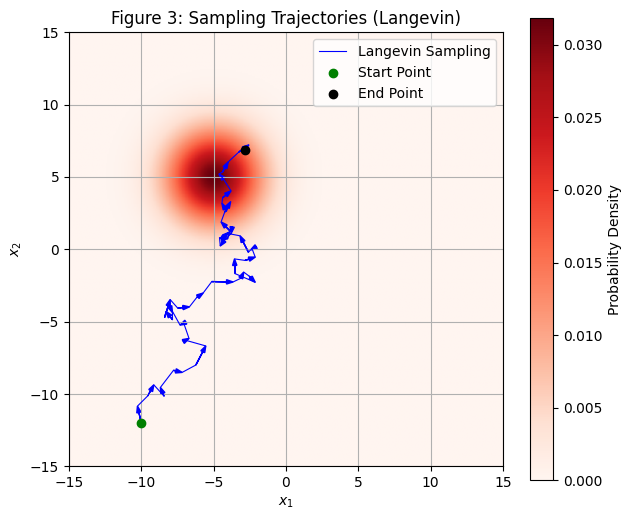

In [112]:
# Generate a sample trajectory starting from a random point
initial_point = np.array([np.floor(np.random.uniform(-15, 15)), np.floor(np.random.uniform(-15, 15))])
trajectory = langevin_sampling(initial_point, mean, cov, step_size=0.15, num_steps=60)

plt.figure(figsize=(7, 6))
plt.imshow(Z, extent=[-15, 15, -15, 15], origin='lower', cmap='Reds', alpha=1)
plt.colorbar(label="Probability Density")

# Plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], linestyle='-', color='blue', label="Langevin Sampling", linewidth = 0.8)

for i in range(0, len(trajectory) - 1, 2):  # Step by 2 to reduce clutter
    plt.arrow(trajectory[i, 0], trajectory[i, 1],
              trajectory[i+1, 0] - trajectory[i, 0],
              trajectory[i+1, 1] - trajectory[i, 1],
              shape='full', color='blue', lw=1, length_includes_head=True, head_width=0.3)

# Highlight start and end points
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label="Start Point", zorder=3)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='black', label="End Point", zorder=3)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Figure 3: Sampling Trajectories (Langevin)")
plt.legend()
plt.grid()
plt.show()


### Now we want you to take 1000 samples using langevin dynamics and 1000 samples using numpy.random.multivariate_normal method. Compare the visualizations.

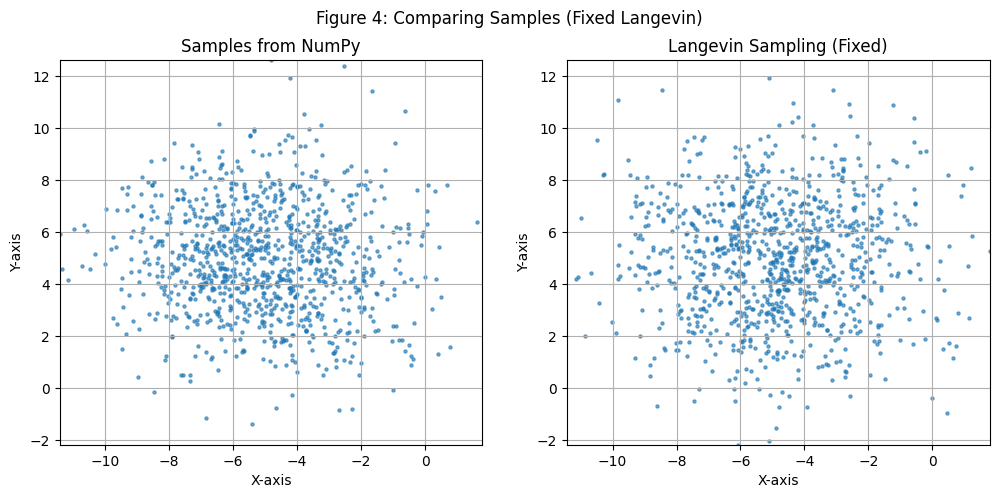

In [113]:
n_samples = 1000

# Generate 1000 samples using NumPy
numpy_samples = np.random.multivariate_normal(mean, cov, n_samples)

# Generate 1000 samples using Langevin Sampling (with diverse initial points)
initial_points = np.random.multivariate_normal(mean, cov * 3, size=n_samples)  # Spread out initial points
langevin_samples = np.array([langevin_sampling(p, mean, cov, step_size=0.05, num_steps=200)[-1] for p in initial_points])

# Compute global min and max for x and y across both methods
min_x = min(np.min(numpy_samples[:, 0]), np.min(langevin_samples[:, 0]))
max_x = max(np.max(numpy_samples[:, 0]), np.max(langevin_samples[:, 0]))

min_y = min(np.min(numpy_samples[:, 1]), np.min(langevin_samples[:, 1]))
max_y = max(np.max(numpy_samples[:, 1]), np.max(langevin_samples[:, 1]))

# Plotting the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for NumPy-generated samples
axes[0].scatter(numpy_samples[:, 0], numpy_samples[:, 1], s=5, alpha=0.6)
axes[0].set_title("Samples from NumPy")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")
axes[0].grid(True)

# Scatter plot for Langevin-generated samples
axes[1].scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=5, alpha=0.6)
axes[1].set_title("Langevin Sampling (Fixed)")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].grid(True)

# Set same x and y limits for both plots
for ax in axes:
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

plt.suptitle("Figure 4: Comparing Samples (Fixed Langevin)")
plt.show()


### How else can you compare these two methods?

In [114]:
# Compute empirical means
mean_numpy = np.mean(numpy_samples, axis=0)
mean_langevin = np.mean(langevin_samples, axis=0)

# Compute empirical covariance matrices
cov_numpy = np.cov(numpy_samples, rowvar=False)
cov_langevin = np.cov(langevin_samples, rowvar=False)
# maryam: 🤢

print("Theoretical Mean:", mean)
print("\nEmpirical Mean (NumPy):", mean_numpy)
print("\nEmpirical Mean (Langevin):", mean_langevin)

print("\nTheoretical Covariance Matrix:\n", cov)
print("\nEmpirical Covariance (NumPy):\n", cov_numpy)
print("\nEmpirical Covariance (Langevin):\n", cov_langevin)


Theoretical Mean: [-5  5]

Empirical Mean (NumPy): [-5.04849909  4.96228644]

Empirical Mean (Langevin): [-4.90403362  4.96710081]

Theoretical Covariance Matrix:
 [[5. 0.]
 [0. 5.]]

Empirical Covariance (NumPy):
 [[ 5.02431533 -0.25730922]
 [-0.25730922  4.43757935]]

Empirical Covariance (Langevin):
 [[5.32253342 0.03185643]
 [0.03185643 5.34201857]]


#### We can compare marginal distributions for X and Y using histograms.

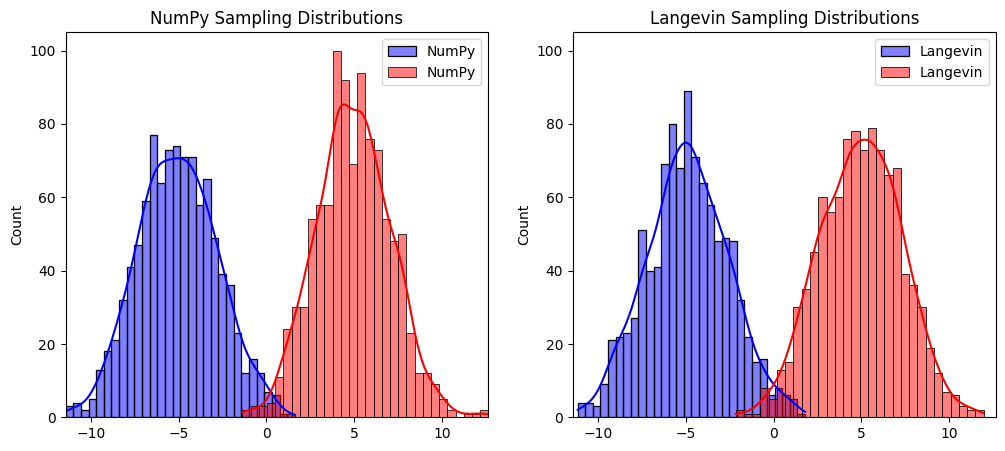

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# NumPy Sampling Histogram
sns.histplot(numpy_samples[:, 0], kde=True, bins=30, color='blue', label="NumPy", ax=axes[0])
sns.histplot(numpy_samples[:, 1], kde=True, bins=30, color='red', label="NumPy", ax=axes[0])
axes[0].set_title("NumPy Sampling Distributions")
axes[0].legend()

# Langevin Sampling Histogram
sns.histplot(langevin_samples[:, 0], kde=True, bins=30, color='blue', label="Langevin", ax=axes[1])
sns.histplot(langevin_samples[:, 1], kde=True, bins=30, color='red', label="Langevin", ax=axes[1])
axes[1].set_title("Langevin Sampling Distributions")
axes[1].legend()

min_x = min(np.min(numpy_samples[:, 0]), np.min(numpy_samples[:, 1]),
            np.min(langevin_samples[:, 0]), np.min(langevin_samples[:, 1]))
max_x = max(np.max(numpy_samples[:, 0]), np.max(numpy_samples[:, 1]),
            np.max(langevin_samples[:, 0]), np.max(langevin_samples[:, 1]))

# Compute global max for y-axis
max_ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

for ax in axes:
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(0, max_ylim)
    
plt.show()


#### The Kullback-Leibler (KL) divergence measures how different two probability distributions are.

KL-Divergence close to 0 → The two distributions are nearly identical.

Higher KL-Divergence → The distributions are different.

Langevin sampling follows the score function, which always moves toward the highest density.

This means low-probability regions are sampled less frequently, potentially improving KL-divergence.

KL-divergence gives higher penalties for underestimating high-density regions than for missing low-density regions.

✔ Effect: If Langevin over-samples high-density regions, KL might look lower than NumPy

In [116]:
# Define theoretical Gaussian distribution
true_gaussian = multivariate_normal(mean=mean, cov=cov)

log_prob_numpy = np.mean(true_gaussian.logpdf(numpy_samples))
log_prob_langevin = np.mean(true_gaussian.logpdf(langevin_samples))

kl_numpy = -log_prob_numpy 
kl_langevin = -log_prob_langevin 

print("KL Divergence (NumPy samples → True Gaussian):", "{:.3f}".format(kl_numpy))
print("KL Divergence (Langevin samples → True Gaussian):", "{:.3f}".format(kl_langevin))


KL Divergence (NumPy samples → True Gaussian): 4.393
KL Divergence (Langevin samples → True Gaussian): 4.514


## **Bonus Question (5% Extra)**

In the sampling part, suppose that instead of a Gaussian distribution, we have a mixture of Gaussians whose density function is:

$$
p(x) = \alpha N(x; \mu_1, \Sigma_1) + (1 - \alpha)N(x; \mu_2, \Sigma_2)
$$

for some $\alpha$ where $0 < \alpha < 1$, and the normal distributions are:

$$
N(x; \mu_1, \Sigma_1) \quad \text{and} \quad N(x; \mu_2, \Sigma_2)
$$

Will we be able to take proper samples using the Langevin Dynamics algorithm? Justify your answer.

---

## **Answer**  
Langevin dynamics follows the gradient of the log probability (score function):

$$
S(x) = \nabla_x \log p(x)
$$

For a single Gaussian, this score function is simple:

$$
S(x) = -\Sigma^{-1} (x - \mu)
$$

However, for a Gaussian Mixture Model (GMM), the score function becomes:

$$
S(x) = \nabla_x \log \left[ \alpha N(x; \mu_1, \Sigma_1) + (1 - \alpha) N(x; \mu_2, \Sigma_2) \right]
$$

Unlike a single Gaussian, this is a weighted sum of gradients, which can create multiple peaks in the probability distribution. This causes several issues:

#### Challenges with Langevin Sampling in a GMM:
If $\mu_1$ and $\mu_2$ are far apart, the Langevin algorithm will get stuck in one mode. The sampler will struggle to transition from one Gaussian to another. This can bias samples towards one Gaussian more than the other. Langevin works well for unimodal distributions. But in multi-modal cases (like a GMM), it does not explore both modes correctly.


---

#### Lets see a mathematical justification

For a Gaussian mixture model (GMM), the score function is:  

$$
S(x) = - \frac{\alpha w_1(x) \Sigma_1^{-1} (x - \mu_1) + (1 - \alpha) w_2(x) \Sigma_2^{-1} (x - \mu_2)}{\alpha w_1(x) + (1 - \alpha) w_2(x)},
$$


where:

```math
w_i(x) = N(x; \mu_i, \Sigma_i)
```

is the contribution of each Gaussian.


When \( $\mu_1$ \) and \( $\mu_2$ \) are far apart, the denominator \( $\alpha w_1(x) + (1 - \alpha) w_2(x)$ \) becomes very small in the low-density transition region, leading to numerical instability in \( $S(x)$ \). This weakens or distorts the gradient, preventing proper movement between modes.


Moreover, Langevin dynamics is governed by a stochastic differential equation, and the probability of crossing modes is exponentially suppressed by the energy barrier separating them. Since transitions require overcoming this barrier, the sampler remains trapped in one mode, leading to biased sampling.


Thus, Langevin dynamics is ineffective for well-separated multimodal distributions like a GMM without modifications such as tempered transitions.

In [117]:
def langevin_gmm_sampling(initial_point, mean1, cov1, mean2, cov2, alpha=0.5, step_size=0.05, num_steps=200):

    cov1_inv = np.linalg.inv(cov1)
    cov2_inv = np.linalg.inv(cov2)
    
    x = np.array(initial_point, dtype=np.float64)  # Initialize at starting point

    for _ in range(num_steps):
        # Compute densities for both Gaussians
        p1 = multivariate_normal.pdf(x, mean=mean1, cov=cov1)
        p2 = multivariate_normal.pdf(x, mean=mean2, cov=cov2)

        # Compute mixture probability weights
        w1 = (alpha * p1) / (alpha * p1 + (1 - alpha) * p2)
        w2 = 1 - w1

        # Compute the score function (gradient of log probability)
        score1 = -np.dot(cov1_inv, (x - mean1))
        score2 = -np.dot(cov2_inv, (x - mean2))
        score = w1 * score1 + w2 * score2  # Weighted combination of both gradients

        # Langevin update step
        x = x + step_size * score + np.sqrt(2 * step_size) * np.random.normal(size=x.shape)

    return x

In [118]:
def sample_from_gmm(n_samples, mean1, cov1, mean2, cov2, alpha=0.5):
    samples = []
    for _ in range(n_samples):
        if np.random.rand() < alpha:
            samples.append(np.random.multivariate_normal(mean1, cov1))
        else:
            samples.append(np.random.multivariate_normal(mean2, cov2))
    return np.array(samples)

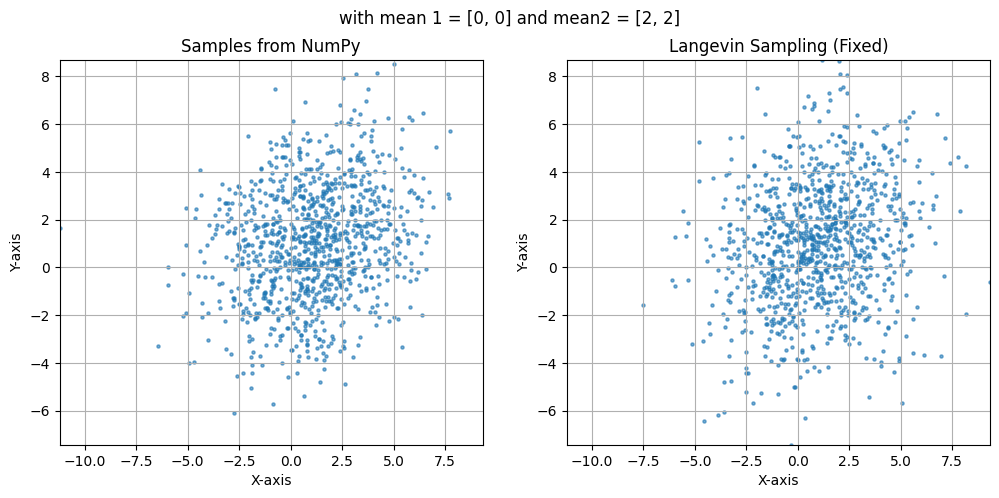

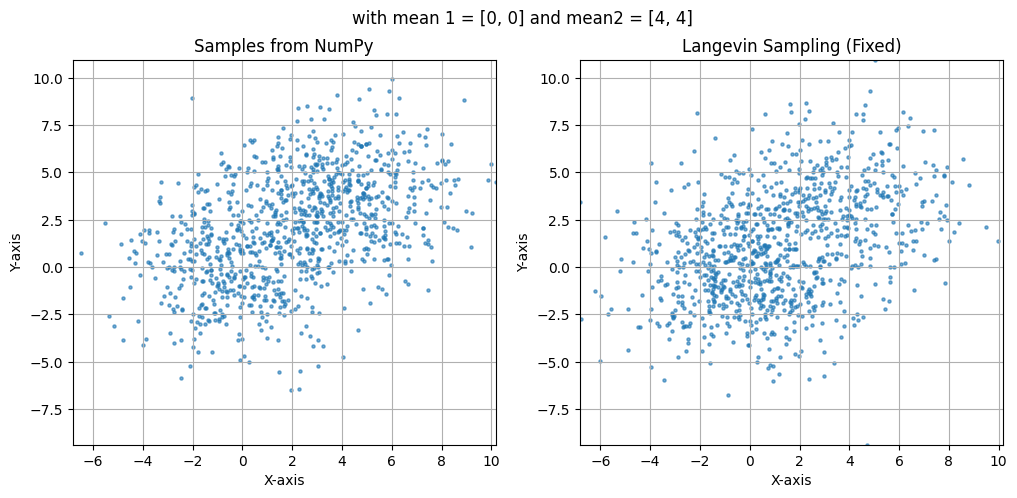

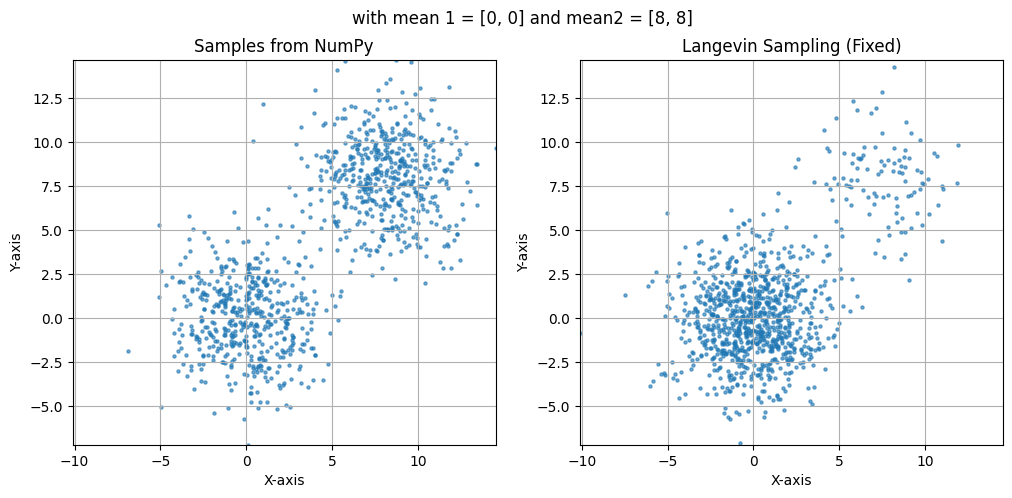

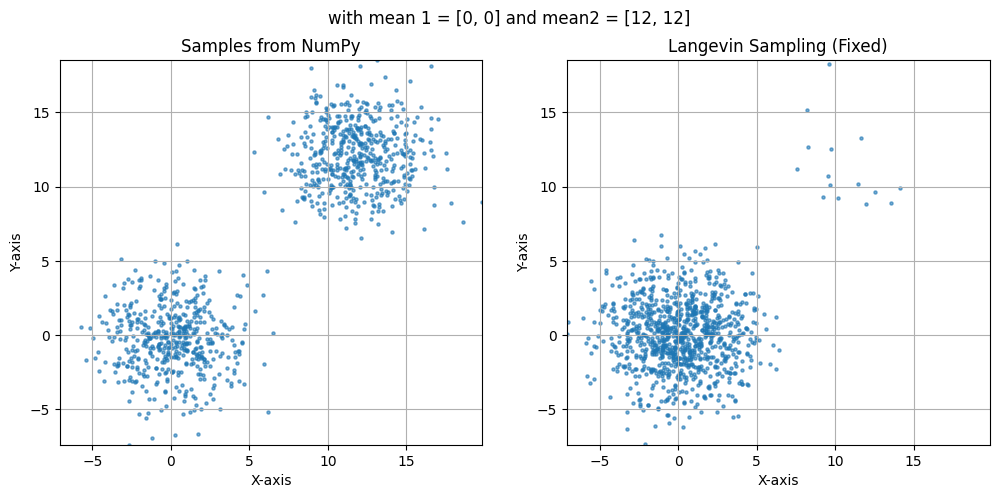

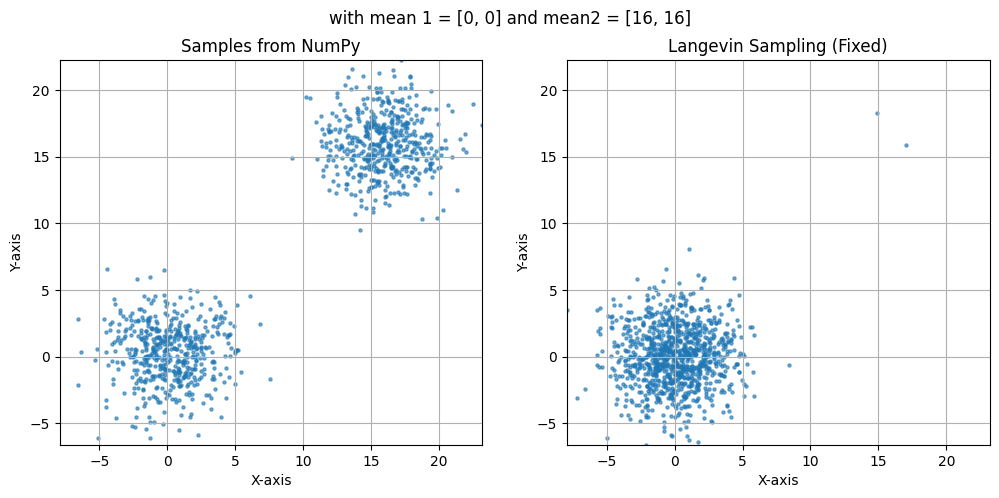

In [119]:
test_means = [
    ([0, 0], [2, 2]), # Closer means
    ([0, 0], [4, 4]),  
    ([0, 0], [8, 8]), 
    ([0, 0], [12, 12]),  
    ([0, 0], [16, 16]) # Wider separation
]

cov1 = 5 * np.eye(2)
cov2 = 5 * np.eye(2)
alpha = 0.5 
n_samples = 1000

for mean1, mean2 in test_means:
    # Sample true GMM points
    numpy_samples = sample_from_gmm(n_samples, mean1, cov1, mean2, cov2, alpha)

    # Generate 1000 samples using Langevin Sampling (with diverse initial points)
    initial_points = np.random.multivariate_normal(mean1, cov1 * 3, size=n_samples)  # Spread out initial points
    langevin_samples = np.array([langevin_gmm_sampling(p, mean1, cov1, mean2, cov2, alpha, step_size=0.05, num_steps=200) for p in initial_points])

    # Compute global min and max for x and y across both methods
    min_x = min(np.min(numpy_samples[:, 0]), np.min(langevin_samples[:, 0]))
    max_x = max(np.max(numpy_samples[:, 0]), np.max(langevin_samples[:, 0]))

    min_y = min(np.min(numpy_samples[:, 1]), np.min(langevin_samples[:, 1]))
    max_y = max(np.max(numpy_samples[:, 1]), np.max(langevin_samples[:, 1]))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter plot for NumPy-generated samples
    axes[0].scatter(numpy_samples[:, 0], numpy_samples[:, 1], s=5, alpha=0.6)
    axes[0].set_title("Samples from NumPy")
    axes[0].set_xlabel("X-axis")
    axes[0].set_ylabel("Y-axis")
    axes[0].grid(True)

    # Scatter plot for Langevin-generated samples
    axes[1].scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=5, alpha=0.6)
    axes[1].set_title("Langevin Sampling (Fixed)")
    axes[1].set_xlabel("X-axis")
    axes[1].set_ylabel("Y-axis")
    axes[1].grid(True)

    for ax in axes:
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    plt.suptitle(f"with mean 1 = {mean1} and mean2 = {mean2}")
    plt.show()

